In [2]:
# Re-import after reset
import json
import pandas as pd
from pathlib import Path

# Load full chunk again
file_path = Path("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl")
with open(file_path, "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# Print shape
df.shape


(53567, 122)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Tuple, Dict

# Dataset class
class HotelReviewDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_cols: List[str], target_col: str = None):
        self.features = torch.FloatTensor(df[feature_cols].values)
        self.target = torch.FloatTensor(df[target_col].values) if target_col else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx: int):
        if self.target is not None:
            return self.features[idx], self.target[idx]
        return self.features[idx]

# Model architecture
class ContentBasedModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, dropout: float = 0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x).squeeze(-1)

# Training function
def train_content_based_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str = 'rating',
    batch_size: int = 64,
    num_epochs: int = 30,
    learning_rate: float = 0.001
) -> Tuple[nn.Module, Dict[str, List[float]]]:

    print("Training content-based model...")

    train_dataset = HotelReviewDataset(train_df, feature_cols, target_col)
    val_dataset = HotelReviewDataset(val_df, feature_cols, target_col)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = ContentBasedModel(input_dim=len(feature_cols))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for features, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    model.load_state_dict(best_model)
    torch.save(model.state_dict(), "/content/drive/MyDrive/new chunk/model_outputs/content_based_model.pt")
    return model, history


Training content-based model...


Epoch 1/30: 100%|██████████| 670/670 [00:01<00:00, 396.07it/s]


Epoch 1: Train Loss = 0.9973, Val Loss = 0.4086


Epoch 2/30: 100%|██████████| 670/670 [00:01<00:00, 397.11it/s]


Epoch 2: Train Loss = 0.6554, Val Loss = 0.3894


Epoch 3/30: 100%|██████████| 670/670 [00:01<00:00, 401.30it/s]


Epoch 3: Train Loss = 0.6198, Val Loss = 0.3685


Epoch 4/30: 100%|██████████| 670/670 [00:02<00:00, 315.31it/s]


Epoch 4: Train Loss = 0.5847, Val Loss = 0.4025


Epoch 5/30: 100%|██████████| 670/670 [00:02<00:00, 295.48it/s]


Epoch 5: Train Loss = 0.5505, Val Loss = 0.3696


Epoch 6/30: 100%|██████████| 670/670 [00:01<00:00, 398.48it/s]


Epoch 6: Train Loss = 0.5254, Val Loss = 0.3703


Epoch 7/30: 100%|██████████| 670/670 [00:01<00:00, 395.21it/s]


Epoch 7: Train Loss = 0.4961, Val Loss = 0.4059


Epoch 8/30: 100%|██████████| 670/670 [00:01<00:00, 394.45it/s]


Epoch 8: Train Loss = 0.4774, Val Loss = 0.3916


Epoch 9/30: 100%|██████████| 670/670 [00:01<00:00, 408.74it/s]


Epoch 9: Train Loss = 0.4639, Val Loss = 0.3653


Epoch 10/30: 100%|██████████| 670/670 [00:01<00:00, 394.58it/s]


Epoch 10: Train Loss = 0.4503, Val Loss = 0.3742


Epoch 11/30: 100%|██████████| 670/670 [00:02<00:00, 307.99it/s]


Epoch 11: Train Loss = 0.4433, Val Loss = 0.3696


Epoch 12/30: 100%|██████████| 670/670 [00:02<00:00, 299.91it/s]


Epoch 12: Train Loss = 0.4298, Val Loss = 0.3740


Epoch 13/30: 100%|██████████| 670/670 [00:01<00:00, 405.59it/s]


Epoch 13: Train Loss = 0.4235, Val Loss = 0.3662


Epoch 14/30: 100%|██████████| 670/670 [00:02<00:00, 282.56it/s]


Epoch 14: Train Loss = 0.4113, Val Loss = 0.3577


Epoch 15/30: 100%|██████████| 670/670 [00:04<00:00, 157.53it/s]


Epoch 15: Train Loss = 0.4085, Val Loss = 0.3629


Epoch 16/30: 100%|██████████| 670/670 [00:03<00:00, 188.45it/s]


Epoch 16: Train Loss = 0.3981, Val Loss = 0.3710


Epoch 17/30: 100%|██████████| 670/670 [00:01<00:00, 355.26it/s]


Epoch 17: Train Loss = 0.3944, Val Loss = 0.3619


Epoch 18/30: 100%|██████████| 670/670 [00:01<00:00, 401.08it/s]


Epoch 18: Train Loss = 0.3903, Val Loss = 0.3575


Epoch 19/30: 100%|██████████| 670/670 [00:01<00:00, 391.52it/s]


Epoch 19: Train Loss = 0.3847, Val Loss = 0.3526


Epoch 20/30: 100%|██████████| 670/670 [00:01<00:00, 388.95it/s]


Epoch 20: Train Loss = 0.3800, Val Loss = 0.3561


Epoch 21/30: 100%|██████████| 670/670 [00:01<00:00, 375.33it/s]


Epoch 21: Train Loss = 0.3764, Val Loss = 0.3516


Epoch 22/30: 100%|██████████| 670/670 [00:01<00:00, 341.64it/s]


Epoch 22: Train Loss = 0.3764, Val Loss = 0.3499


Epoch 23/30: 100%|██████████| 670/670 [00:02<00:00, 270.45it/s]


Epoch 23: Train Loss = 0.3732, Val Loss = 0.3615


Epoch 24/30: 100%|██████████| 670/670 [00:01<00:00, 395.79it/s]


Epoch 24: Train Loss = 0.3695, Val Loss = 0.3534


Epoch 25/30: 100%|██████████| 670/670 [00:01<00:00, 397.88it/s]


Epoch 25: Train Loss = 0.3667, Val Loss = 0.3532


Epoch 26/30: 100%|██████████| 670/670 [00:01<00:00, 387.37it/s]


Epoch 26: Train Loss = 0.3666, Val Loss = 0.3496


Epoch 27/30: 100%|██████████| 670/670 [00:01<00:00, 394.87it/s]


Epoch 27: Train Loss = 0.3634, Val Loss = 0.3510


Epoch 28/30: 100%|██████████| 670/670 [00:01<00:00, 387.32it/s]


Epoch 28: Train Loss = 0.3606, Val Loss = 0.3551


Epoch 29/30: 100%|██████████| 670/670 [00:02<00:00, 307.72it/s]


Epoch 29: Train Loss = 0.3602, Val Loss = 0.3513


Epoch 30/30: 100%|██████████| 670/670 [00:02<00:00, 286.90it/s]


Epoch 30: Train Loss = 0.3589, Val Loss = 0.3514


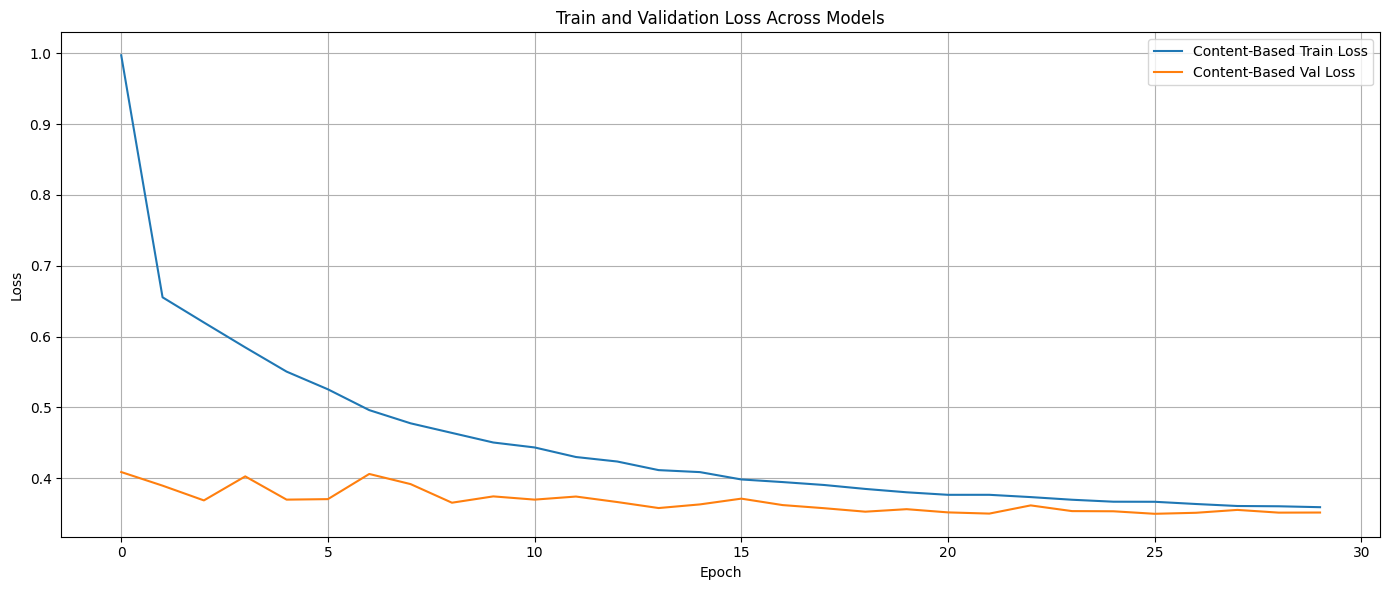

In [4]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load the review dataset
df = pd.read_json(Path("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl"), lines=True)

# 2. Train/val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Define feature columns for content-based model
feature_cols = [
    col for col in df.columns
    if col.startswith('rating_') or col.startswith('tfidf_') or
    col.endswith('_sentiment_compound') or col.endswith('_sentiment_positive') or
    col.endswith('_sentiment_neutral') or col.endswith('_sentiment_negative')
]

# 4. Train the content-based model
model, history = train_content_based_model(
    train_df=train_df,
    val_df=val_df,
    feature_cols=feature_cols,
    target_col='rating',
    batch_size=64,
    num_epochs=30,
    learning_rate=0.001
)

# 5. Define the plotting function
def plot_training_history(histories, model_names):
    """
    Plot training and validation loss for multiple models.

    Args:
        histories (List[Dict[str, List[float]]]): List of training histories.
        model_names (List[str]): Corresponding model names.
    """
    plt.figure(figsize=(14, 6))
    for history, name in zip(histories, model_names):
        plt.plot(history['train_loss'], label=f'{name} Train Loss')
        plt.plot(history['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss Across Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 6. Plot the training graph
plot_training_history([history], ["Content-Based"])

In [5]:
torch.save(model.state_dict(), "/content/drive/MyDrive/new chunk/model_outputs/content_based_model.pt")


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Tuple, Dict
import pandas as pd

# Dataset class
class HotelReviewDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_cols: List[str], target_col: str = None):
        self.features = torch.FloatTensor(df[feature_cols].values)
        self.target = torch.FloatTensor(df[target_col].values) if target_col else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx: int):
        if self.target is not None:
            return self.features[idx], self.target[idx]
        return self.features[idx]

# Model architecture
class RatingPredictionModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int] = [256, 128, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze(-1)

# Training function
def train_rating_prediction_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str = 'rating',
    batch_size: int = 64,
    num_epochs: int = 30,
    learning_rate: float = 0.001
) -> Tuple[nn.Module, Dict[str, List[float]]]:

    print("Training rating prediction model...")

    train_dataset = HotelReviewDataset(train_df, feature_cols, target_col)
    val_dataset = HotelReviewDataset(val_df, feature_cols, target_col)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = RatingPredictionModel(input_dim=len(feature_cols))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for features, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    model.load_state_dict(best_model)
    return model, history


Training rating prediction model...


Epoch 1/30: 100%|██████████| 670/670 [00:02<00:00, 257.22it/s]


Epoch 1: Train Loss = 4.5032, Val Loss = 0.3610


Epoch 2/30: 100%|██████████| 670/670 [00:04<00:00, 141.04it/s]


Epoch 2: Train Loss = 0.7731, Val Loss = 0.3586


Epoch 3/30: 100%|██████████| 670/670 [00:02<00:00, 247.84it/s]


Epoch 3: Train Loss = 0.6121, Val Loss = 0.3467


Epoch 4/30: 100%|██████████| 670/670 [00:02<00:00, 247.93it/s]


Epoch 4: Train Loss = 0.5343, Val Loss = 0.3350


Epoch 5/30: 100%|██████████| 670/670 [00:02<00:00, 250.19it/s]


Epoch 5: Train Loss = 0.4955, Val Loss = 0.3435


Epoch 6/30: 100%|██████████| 670/670 [00:03<00:00, 198.52it/s]


Epoch 6: Train Loss = 0.4658, Val Loss = 0.3340


Epoch 7/30: 100%|██████████| 670/670 [00:03<00:00, 178.21it/s]


Epoch 7: Train Loss = 0.4478, Val Loss = 0.3331


Epoch 8/30: 100%|██████████| 670/670 [00:03<00:00, 204.32it/s]


Epoch 8: Train Loss = 0.4348, Val Loss = 0.3289


Epoch 9/30: 100%|██████████| 670/670 [00:02<00:00, 245.55it/s]


Epoch 9: Train Loss = 0.4249, Val Loss = 0.3293


Epoch 10/30: 100%|██████████| 670/670 [00:03<00:00, 181.71it/s]


Epoch 10: Train Loss = 0.4143, Val Loss = 0.3269


Epoch 11/30: 100%|██████████| 670/670 [00:02<00:00, 230.47it/s]


Epoch 11: Train Loss = 0.4114, Val Loss = 0.3244


Epoch 12/30: 100%|██████████| 670/670 [00:02<00:00, 248.56it/s]


Epoch 12: Train Loss = 0.4056, Val Loss = 0.3256


Epoch 13/30: 100%|██████████| 670/670 [00:02<00:00, 248.51it/s]


Epoch 13: Train Loss = 0.3983, Val Loss = 0.3298


Epoch 14/30: 100%|██████████| 670/670 [00:03<00:00, 207.05it/s]


Epoch 14: Train Loss = 0.3983, Val Loss = 0.3207


Epoch 15/30: 100%|██████████| 670/670 [00:03<00:00, 199.12it/s]


Epoch 15: Train Loss = 0.3957, Val Loss = 0.3215


Epoch 16/30: 100%|██████████| 670/670 [00:02<00:00, 242.91it/s]


Epoch 16: Train Loss = 0.3896, Val Loss = 0.3269


Epoch 17/30: 100%|██████████| 670/670 [00:02<00:00, 247.58it/s]


Epoch 17: Train Loss = 0.3889, Val Loss = 0.3233


Epoch 18/30: 100%|██████████| 670/670 [00:02<00:00, 229.13it/s]


Epoch 18: Train Loss = 0.3840, Val Loss = 0.3254


Epoch 19/30: 100%|██████████| 670/670 [00:03<00:00, 180.14it/s]


Epoch 19: Train Loss = 0.3836, Val Loss = 0.3221


Epoch 20/30: 100%|██████████| 670/670 [00:02<00:00, 246.22it/s]


Epoch 20: Train Loss = 0.3761, Val Loss = 0.3193


Epoch 21/30: 100%|██████████| 670/670 [00:02<00:00, 237.98it/s]


Epoch 21: Train Loss = 0.3760, Val Loss = 0.3228


Epoch 22/30: 100%|██████████| 670/670 [00:02<00:00, 243.33it/s]


Epoch 22: Train Loss = 0.3718, Val Loss = 0.3196


Epoch 23/30: 100%|██████████| 670/670 [00:05<00:00, 119.77it/s]


Epoch 23: Train Loss = 0.3747, Val Loss = 0.3205


Epoch 24/30: 100%|██████████| 670/670 [00:02<00:00, 241.96it/s]


Epoch 24: Train Loss = 0.3694, Val Loss = 0.3185


Epoch 25/30: 100%|██████████| 670/670 [00:02<00:00, 243.81it/s]


Epoch 25: Train Loss = 0.3700, Val Loss = 0.3257


Epoch 26/30: 100%|██████████| 670/670 [00:02<00:00, 236.05it/s]


Epoch 26: Train Loss = 0.3682, Val Loss = 0.3236


Epoch 27/30: 100%|██████████| 670/670 [00:03<00:00, 177.17it/s]


Epoch 27: Train Loss = 0.3662, Val Loss = 0.3168


Epoch 28/30: 100%|██████████| 670/670 [00:02<00:00, 236.62it/s]


Epoch 28: Train Loss = 0.3631, Val Loss = 0.3185


Epoch 29/30: 100%|██████████| 670/670 [00:02<00:00, 238.78it/s]


Epoch 29: Train Loss = 0.3597, Val Loss = 0.3185


Epoch 30/30: 100%|██████████| 670/670 [00:02<00:00, 235.57it/s]


Epoch 30: Train Loss = 0.3564, Val Loss = 0.3192


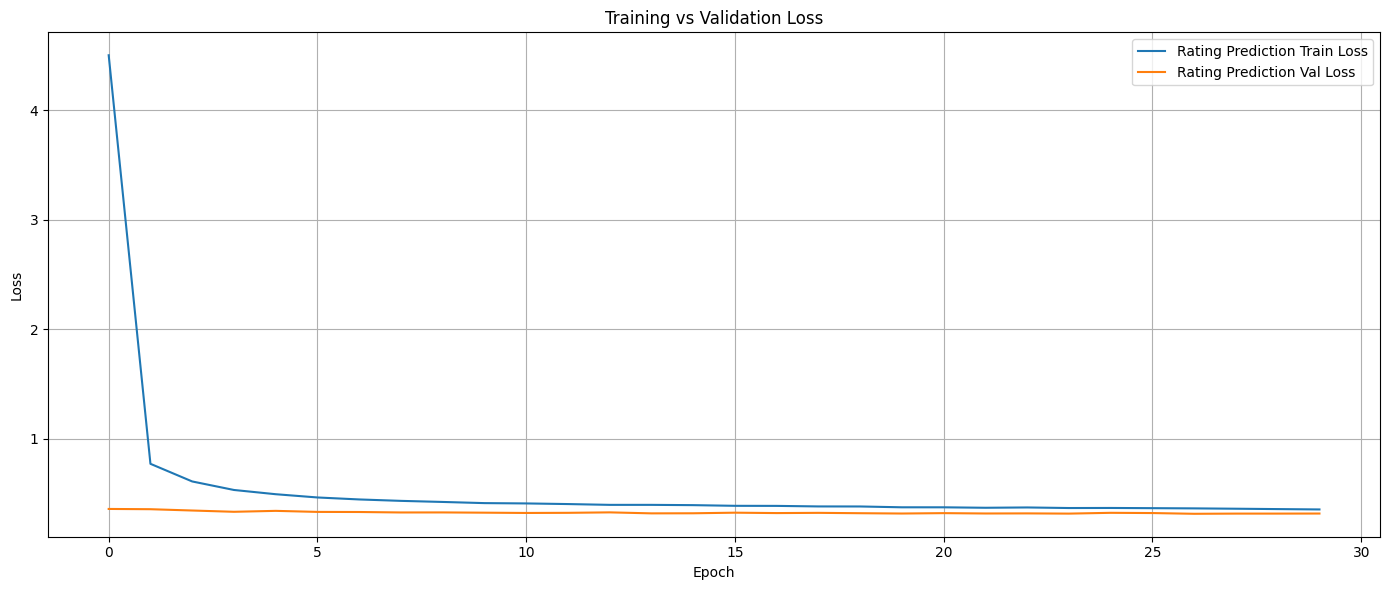

In [7]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# 1. Load your review chunk
chunk_file = Path("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl")
df = pd.read_json(chunk_file, lines=True)

# 2. Train/Validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Define feature columns used in the model
feature_cols = [
    col for col in df.columns
    if col.startswith('rating_') or col.startswith('tfidf_') or
    col.endswith('_sentiment_compound') or col.endswith('_sentiment_positive') or
    col.endswith('_sentiment_neutral') or col.endswith('_sentiment_negative')
]

# 4. Train the rating prediction model
model, history = train_rating_prediction_model(
    train_df=train_df,
    val_df=val_df,
    feature_cols=feature_cols,
    target_col='rating',
    batch_size=64,
    num_epochs=30,
    learning_rate=0.001
)

# 5. Save model
torch.save(model.state_dict(), "/content/drive/MyDrive/new chunk/model_outputs/rating_prediction_model.pt")

# 6. Plot training/validation loss
def plot_training_history(histories, model_names):
    plt.figure(figsize=(14, 6))
    for history, name in zip(histories, model_names):
        plt.plot(history['train_loss'], label=f'{name} Train Loss')
        plt.plot(history['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history([history], ["Rating Prediction"])


MODEL 2

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import joblib

# Feature columns for hotels
feature_cols = [
    col for col in df.columns
    if col.startswith('rating_') or col.startswith('tfidf_') or
    col.endswith('_sentiment_compound') or col.endswith('_sentiment_positive') or
    col.endswith('_sentiment_neutral') or col.endswith('_sentiment_negative')
]

# Group by hotel_id and take mean to get hotel feature vectors
hotel_features = df.groupby("hotel_id")[feature_cols].mean()

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(hotel_features)

# Train Nearest Neighbors model (cosine similarity)
nn_model = NearestNeighbors(n_neighbors=6, metric="cosine")  # 6 to include the hotel itself
nn_model.fit(scaled_features)

# Save the model and scaler
import joblib
joblib.dump(nn_model, "/content/drive/MyDrive/new chunk/model_outputs/similar_hotel_model.pkl")
joblib.dump(scaler, "/content/drive/MyDrive/new chunk/model_outputs/similar_hotel_scaler.pkl")

# Show top-5 similar hotels for 5 random hotels
hotel_ids = hotel_features.index.tolist()
scaled_input = scaled_features

distances, indices = nn_model.kneighbors(scaled_input)

print("\nTop-5 Similar Hotels (excluding self):")
for i in range(min(5, len(hotel_ids))):
    print(f"\nHotel ID {hotel_ids[i]} is similar to:")
    for j in range(1, 6):  # skip self (index 0)
        similar_id = hotel_ids[indices[i][j]]
        print(f"  {j}. Hotel ID {similar_id} (Distance: {distances[i][j]:.4f})")



Top-5 Similar Hotels (excluding self):

Hotel ID 0 is similar to:
  1. Hotel ID 343 (Distance: 0.7278)
  2. Hotel ID 300 (Distance: 0.7940)
  3. Hotel ID 66 (Distance: 0.7992)
  4. Hotel ID 319 (Distance: 0.8009)
  5. Hotel ID 327 (Distance: 0.8159)

Hotel ID 1 is similar to:
  1. Hotel ID 344 (Distance: 0.7103)
  2. Hotel ID 81 (Distance: 0.7253)
  3. Hotel ID 194 (Distance: 0.7778)
  4. Hotel ID 236 (Distance: 0.7793)
  5. Hotel ID 144 (Distance: 0.7838)

Hotel ID 2 is similar to:
  1. Hotel ID 159 (Distance: 0.4554)
  2. Hotel ID 102 (Distance: 0.5814)
  3. Hotel ID 114 (Distance: 0.5887)
  4. Hotel ID 38 (Distance: 0.5909)
  5. Hotel ID 115 (Distance: 0.5915)

Hotel ID 3 is similar to:
  1. Hotel ID 303 (Distance: 0.6873)
  2. Hotel ID 175 (Distance: 0.7209)
  3. Hotel ID 64 (Distance: 0.7342)
  4. Hotel ID 118 (Distance: 0.7378)
  5. Hotel ID 156 (Distance: 0.7396)

Hotel ID 4 is similar to:
  1. Hotel ID 199 (Distance: 0.6013)
  2. Hotel ID 181 (Distance: 0.6269)
  3. Hotel ID 1

MODEL 3

In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib

# 1. Load your dataset
df = pd.read_json(Path("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl"), lines=True)

# 2. Clip ratings to ensure scale is 1–5
df["rating"] = df["rating"].clip(1, 5)

# 3. Define content-based feature columns for hotels
feature_cols = [
    col for col in df.columns
    if col.startswith('rating_') or col.startswith('tfidf_') or
    col.endswith('_sentiment_compound') or col.endswith('_sentiment_positive') or
    col.endswith('_sentiment_neutral') or col.endswith('_sentiment_negative')
]

# 4. Compute average rating per (user, hotel) pair
user_hotel_ratings = df.groupby(['author_id', 'hotel_id'])['rating'].mean().reset_index()

# 5. Create a user-hotel matrix (without filling missing with 0)
user_hotel_matrix = user_hotel_ratings.pivot(
    index='author_id',
    columns='hotel_id',
    values='rating'
)

# 6. Filter out sparse hotels (rated by < 5 users)
hotel_counts = user_hotel_matrix.count()
valid_hotels = hotel_counts[hotel_counts > 5].index
user_hotel_matrix = user_hotel_matrix[valid_hotels]

# 7. Get hotel features for valid hotels
hotel_features = df.groupby('hotel_id')[feature_cols].mean()
X = hotel_features.loc[valid_hotels]

# 8. Define y as average rating across users for each hotel
y = user_hotel_matrix[valid_hotels].mean()

# 9. Print target summary
print("Training on hotel ratings with stats:")
print(y.describe())

# 10. Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 11. Save model and hotel features
joblib.dump(rf_model, "/content/drive/MyDrive/new chunk/model_outputs/hotel_recommender_model.pkl")
joblib.dump(hotel_features, "/content/drive/MyDrive/new chunk/model_outputs/hotel_features.pkl")

# 12. Predict and show top hotels
predictions = rf_model.predict(hotel_features)
hotel_ids = hotel_features.index

print("\nTop 5 Recommended Hotels (Predicted Ratings):")
top_indices = np.argsort(predictions)[::-1][:5]
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. Hotel ID {hotel_ids[idx]} → Predicted Rating: {predictions[idx]:.2f}")


Training on hotel ratings with stats:
count    329.000000
mean       4.092764
std        0.477885
min        2.525862
25%        3.796610
50%        4.132438
75%        4.430730
max        5.000000
dtype: float64

Top 5 Recommended Hotels (Predicted Ratings):
1. Hotel ID 3 → Predicted Rating: 4.96
2. Hotel ID 328 → Predicted Rating: 4.93
3. Hotel ID 309 → Predicted Rating: 4.92
4. Hotel ID 14 → Predicted Rating: 4.91
5. Hotel ID 327 → Predicted Rating: 4.90


MODEL 4

[Hybrid] Epoch 1/30: 100%|██████████| 670/670 [00:13<00:00, 49.04it/s]


[Hybrid] Epoch 1: Train Loss = 0.9335, Val Loss = 0.3879


[Hybrid] Epoch 2/30: 100%|██████████| 670/670 [00:13<00:00, 49.64it/s]


[Hybrid] Epoch 2: Train Loss = 0.3991, Val Loss = 0.3841


[Hybrid] Epoch 3/30: 100%|██████████| 670/670 [00:12<00:00, 53.95it/s]


[Hybrid] Epoch 3: Train Loss = 0.2133, Val Loss = 0.3963


[Hybrid] Epoch 4/30: 100%|██████████| 670/670 [00:13<00:00, 48.90it/s]


[Hybrid] Epoch 4: Train Loss = 0.1087, Val Loss = 0.3997


[Hybrid] Epoch 5/30: 100%|██████████| 670/670 [00:12<00:00, 53.51it/s]


[Hybrid] Epoch 5: Train Loss = 0.0567, Val Loss = 0.3985


[Hybrid] Epoch 6/30: 100%|██████████| 670/670 [00:12<00:00, 54.49it/s]


[Hybrid] Epoch 6: Train Loss = 0.0380, Val Loss = 0.4084


[Hybrid] Epoch 7/30: 100%|██████████| 670/670 [00:12<00:00, 54.20it/s]


[Hybrid] Epoch 7: Train Loss = 0.0304, Val Loss = 0.4074


[Hybrid] Epoch 8/30: 100%|██████████| 670/670 [00:12<00:00, 54.50it/s]


[Hybrid] Epoch 8: Train Loss = 0.0274, Val Loss = 0.4116


[Hybrid] Epoch 9/30: 100%|██████████| 670/670 [00:12<00:00, 52.90it/s]


[Hybrid] Epoch 9: Train Loss = 0.0259, Val Loss = 0.4181


[Hybrid] Epoch 10/30: 100%|██████████| 670/670 [00:12<00:00, 52.74it/s]


[Hybrid] Epoch 10: Train Loss = 0.0250, Val Loss = 0.4089


[Hybrid] Epoch 11/30: 100%|██████████| 670/670 [00:12<00:00, 52.66it/s]


[Hybrid] Epoch 11: Train Loss = 0.0233, Val Loss = 0.3981


[Hybrid] Epoch 12/30: 100%|██████████| 670/670 [00:12<00:00, 52.54it/s]


[Hybrid] Epoch 12: Train Loss = 0.0220, Val Loss = 0.4073


[Hybrid] Epoch 13/30: 100%|██████████| 670/670 [00:12<00:00, 52.81it/s]


[Hybrid] Epoch 13: Train Loss = 0.0206, Val Loss = 0.4279


[Hybrid] Epoch 14/30: 100%|██████████| 670/670 [00:12<00:00, 52.86it/s]


[Hybrid] Epoch 14: Train Loss = 0.0188, Val Loss = 0.4199


[Hybrid] Epoch 15/30: 100%|██████████| 670/670 [00:12<00:00, 52.30it/s]


[Hybrid] Epoch 15: Train Loss = 0.0178, Val Loss = 0.4237


[Hybrid] Epoch 16/30: 100%|██████████| 670/670 [00:12<00:00, 52.05it/s]


[Hybrid] Epoch 16: Train Loss = 0.0170, Val Loss = 0.4232


[Hybrid] Epoch 17/30: 100%|██████████| 670/670 [00:12<00:00, 52.23it/s]


[Hybrid] Epoch 17: Train Loss = 0.0162, Val Loss = 0.4420


[Hybrid] Epoch 18/30: 100%|██████████| 670/670 [00:12<00:00, 52.43it/s]


[Hybrid] Epoch 18: Train Loss = 0.0157, Val Loss = 0.4301


[Hybrid] Epoch 19/30: 100%|██████████| 670/670 [00:15<00:00, 44.44it/s]


[Hybrid] Epoch 19: Train Loss = 0.0150, Val Loss = 0.4301


[Hybrid] Epoch 20/30: 100%|██████████| 670/670 [00:15<00:00, 43.01it/s]


[Hybrid] Epoch 20: Train Loss = 0.0142, Val Loss = 0.4346


[Hybrid] Epoch 21/30: 100%|██████████| 670/670 [00:12<00:00, 51.93it/s]


[Hybrid] Epoch 21: Train Loss = 0.0136, Val Loss = 0.4458


[Hybrid] Epoch 22/30: 100%|██████████| 670/670 [00:12<00:00, 51.83it/s]


[Hybrid] Epoch 22: Train Loss = 0.0132, Val Loss = 0.4455


[Hybrid] Epoch 23/30: 100%|██████████| 670/670 [00:12<00:00, 51.92it/s]


[Hybrid] Epoch 23: Train Loss = 0.0129, Val Loss = 0.4649


[Hybrid] Epoch 24/30: 100%|██████████| 670/670 [00:12<00:00, 52.24it/s]


[Hybrid] Epoch 24: Train Loss = 0.0130, Val Loss = 0.4263


[Hybrid] Epoch 25/30: 100%|██████████| 670/670 [00:12<00:00, 52.00it/s]


[Hybrid] Epoch 25: Train Loss = 0.0124, Val Loss = 0.4259


[Hybrid] Epoch 26/30: 100%|██████████| 670/670 [00:12<00:00, 52.13it/s]


[Hybrid] Epoch 26: Train Loss = 0.0122, Val Loss = 0.4308


[Hybrid] Epoch 27/30: 100%|██████████| 670/670 [00:13<00:00, 51.49it/s]


[Hybrid] Epoch 27: Train Loss = 0.0113, Val Loss = 0.4091


[Hybrid] Epoch 28/30: 100%|██████████| 670/670 [00:12<00:00, 52.01it/s]


[Hybrid] Epoch 28: Train Loss = 0.0115, Val Loss = 0.4470


[Hybrid] Epoch 29/30: 100%|██████████| 670/670 [00:12<00:00, 51.58it/s]


[Hybrid] Epoch 29: Train Loss = 0.0114, Val Loss = 0.4218


[Hybrid] Epoch 30/30: 100%|██████████| 670/670 [00:12<00:00, 51.75it/s]


[Hybrid] Epoch 30: Train Loss = 0.0115, Val Loss = 0.4123


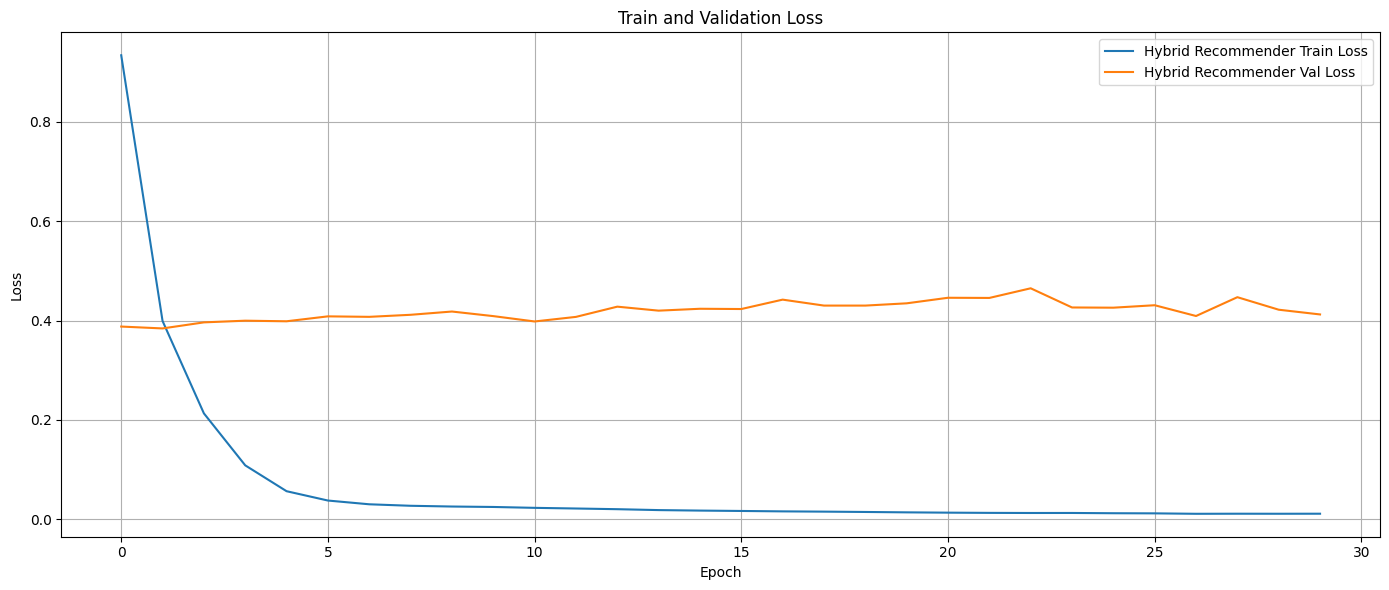

In [15]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load the review chunk
df = pd.read_json(Path("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl"), lines=True)

# 2. Ensure valid ratings and IDs
df = df.dropna(subset=["author_id", "hotel_id", "rating"])
df["rating"] = df["rating"].clip(1, 5)
df["user_id"] = df["author_id"].astype("category").cat.codes
df["item_id"] = df["hotel_id"].astype("category").cat.codes

# 3. Content feature columns (used in hybrid model)
feature_cols = [
    col for col in df.columns
    if col.startswith('rating_') or col.startswith('tfidf_') or
    col.endswith('_sentiment_compound') or col.endswith('_sentiment_positive') or
    col.endswith('_sentiment_neutral') or col.endswith('_sentiment_negative')
]

# 4. Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 5. Count users/items for embedding
num_users = df["user_id"].nunique()
num_items = df["item_id"].nunique()

# 6. Call the training function
model, history = train_hybrid_model(
    train_df=train_df,
    val_df=val_df,
    feature_cols=feature_cols,
    num_users=num_users,
    num_items=num_items,
    user_col="user_id",
    item_col="item_id",
    target_col="rating",
    batch_size=64,
    num_epochs=30,
    learning_rate=0.001
)

# 7. Plot loss curves
import matplotlib.pyplot as plt

def plot_training_history(histories, model_names):
    plt.figure(figsize=(14, 6))
    for history, name in zip(histories, model_names):
        plt.plot(history['train_loss'], label=f'{name} Train Loss')
        plt.plot(history['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history([history], ["Hybrid Recommender"])


Model 5

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from typing import List, Dict, Tuple

# Dataset
class HotelFeatureDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_cols: List[str], target_col: str = 'rating'):
        self.features = torch.FloatTensor(df[feature_cols].values)
        self.ratings = torch.FloatTensor(df[target_col].values)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.features[idx], self.ratings[idx]

# Autoencoder model
class FeatureAutoencoder(nn.Module):
    def __init__(self, input_dim: int, bottleneck_dim: int = 64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Rating predictor
class RatingRegressor(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)


In [31]:
# Load data
df = pd.read_json("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl", lines=True)
df["rating"] = df["rating"].clip(1, 5)

# Define features
feature_cols = [col for col in df.columns if col.startswith("tfidf_") or "sentiment" in col or col.startswith("rating_")]

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_ds = HotelFeatureDataset(train_df, feature_cols)
val_ds = HotelFeatureDataset(val_df, feature_cols)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Init models
input_dim = len(feature_cols)
autoencoder = FeatureAutoencoder(input_dim=input_dim)
regressor = RatingRegressor(input_dim=64)  # bottleneck size

# Optimizers
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
reg_optimizer = optim.Adam(regressor.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train both
NUM_EPOCHS = 30
for epoch in range(NUM_EPOCHS):
    autoencoder.train()
    regressor.train()
    train_loss = 0.0

    for features, ratings in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
        ae_optimizer.zero_grad()
        reg_optimizer.zero_grad()

        encoded, decoded = autoencoder(features)
        pred_ratings = regressor(encoded)

        loss_ae = nn.functional.mse_loss(decoded, features)
        loss_rating = criterion(pred_ratings, ratings)

        loss = loss_ae + loss_rating
        loss.backward()

        ae_optimizer.step()
        reg_optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}")


[Epoch 1]: 100%|██████████| 670/670 [00:02<00:00, 230.16it/s]


Epoch 1: Train Loss = 1.0459


[Epoch 2]: 100%|██████████| 670/670 [00:02<00:00, 258.09it/s]


Epoch 2: Train Loss = 0.6226


[Epoch 3]: 100%|██████████| 670/670 [00:02<00:00, 257.83it/s]


Epoch 3: Train Loss = 0.5841


[Epoch 4]: 100%|██████████| 670/670 [00:02<00:00, 260.56it/s]


Epoch 4: Train Loss = 0.5589


[Epoch 5]: 100%|██████████| 670/670 [00:03<00:00, 201.07it/s]


Epoch 5: Train Loss = 0.5388


[Epoch 6]: 100%|██████████| 670/670 [00:03<00:00, 222.63it/s]


Epoch 6: Train Loss = 0.5161


[Epoch 7]: 100%|██████████| 670/670 [00:02<00:00, 257.55it/s]


Epoch 7: Train Loss = 0.4991


[Epoch 8]: 100%|██████████| 670/670 [00:02<00:00, 258.77it/s]


Epoch 8: Train Loss = 0.4842


[Epoch 9]: 100%|██████████| 670/670 [00:02<00:00, 261.27it/s]


Epoch 9: Train Loss = 0.4587


[Epoch 10]: 100%|██████████| 670/670 [00:03<00:00, 195.25it/s]


Epoch 10: Train Loss = 0.4530


[Epoch 11]: 100%|██████████| 670/670 [00:02<00:00, 239.46it/s]


Epoch 11: Train Loss = 0.4377


[Epoch 12]: 100%|██████████| 670/670 [00:02<00:00, 262.13it/s]


Epoch 12: Train Loss = 0.4260


[Epoch 13]: 100%|██████████| 670/670 [00:02<00:00, 263.48it/s]


Epoch 13: Train Loss = 0.4151


[Epoch 14]: 100%|██████████| 670/670 [00:03<00:00, 178.81it/s]


Epoch 14: Train Loss = 0.4031


[Epoch 15]: 100%|██████████| 670/670 [00:04<00:00, 159.11it/s]


Epoch 15: Train Loss = 0.3960


[Epoch 16]: 100%|██████████| 670/670 [00:02<00:00, 261.39it/s]


Epoch 16: Train Loss = 0.3873


[Epoch 17]: 100%|██████████| 670/670 [00:02<00:00, 262.77it/s]


Epoch 17: Train Loss = 0.3808


[Epoch 18]: 100%|██████████| 670/670 [00:02<00:00, 259.88it/s]


Epoch 18: Train Loss = 0.3753


[Epoch 19]: 100%|██████████| 670/670 [00:03<00:00, 210.98it/s]


Epoch 19: Train Loss = 0.3704


[Epoch 20]: 100%|██████████| 670/670 [00:03<00:00, 204.90it/s]


Epoch 20: Train Loss = 0.3664


[Epoch 21]: 100%|██████████| 670/670 [00:02<00:00, 256.89it/s]


Epoch 21: Train Loss = 0.3612


[Epoch 22]: 100%|██████████| 670/670 [00:02<00:00, 256.64it/s]


Epoch 22: Train Loss = 0.3570


[Epoch 23]: 100%|██████████| 670/670 [00:02<00:00, 253.68it/s]


Epoch 23: Train Loss = 0.3525


[Epoch 24]: 100%|██████████| 670/670 [00:03<00:00, 191.87it/s]


Epoch 24: Train Loss = 0.3508


[Epoch 25]: 100%|██████████| 670/670 [00:03<00:00, 223.12it/s]


Epoch 25: Train Loss = 0.3473


[Epoch 26]: 100%|██████████| 670/670 [00:02<00:00, 255.27it/s]


Epoch 26: Train Loss = 0.3431


[Epoch 27]: 100%|██████████| 670/670 [00:02<00:00, 256.41it/s]


Epoch 27: Train Loss = 0.3397


[Epoch 28]: 100%|██████████| 670/670 [00:02<00:00, 255.72it/s]


Epoch 28: Train Loss = 0.3374


[Epoch 29]: 100%|██████████| 670/670 [00:03<00:00, 174.67it/s]


Epoch 29: Train Loss = 0.3370


[Epoch 30]: 100%|██████████| 670/670 [00:03<00:00, 210.56it/s]

Epoch 30: Train Loss = 0.3348


In [35]:
torch.save(autoencoder.state_dict(), "/content/drive/MyDrive/new chunk/model_outputs/autoencoder.pt")
torch.save(regressor.state_dict(), "/content/drive/MyDrive/new chunk/model_outputs/autoencoder_regressor.pt")


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate on validation set
autoencoder.eval()
regressor.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for features, ratings in val_loader:
        encoded, _ = autoencoder(features)
        preds = regressor(encoded)
        all_preds.extend(preds.tolist())
        all_targets.extend(ratings.tolist())

rmse = mean_squared_error(all_targets, all_preds)
mae = mean_absolute_error(all_targets, all_preds)

print(f"\n✅ RMSE: {rmse:.4f}")
print(f"✅ MAE:  {mae:.4f}")



✅ RMSE: 0.3516
✅ MAE:  0.4455


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


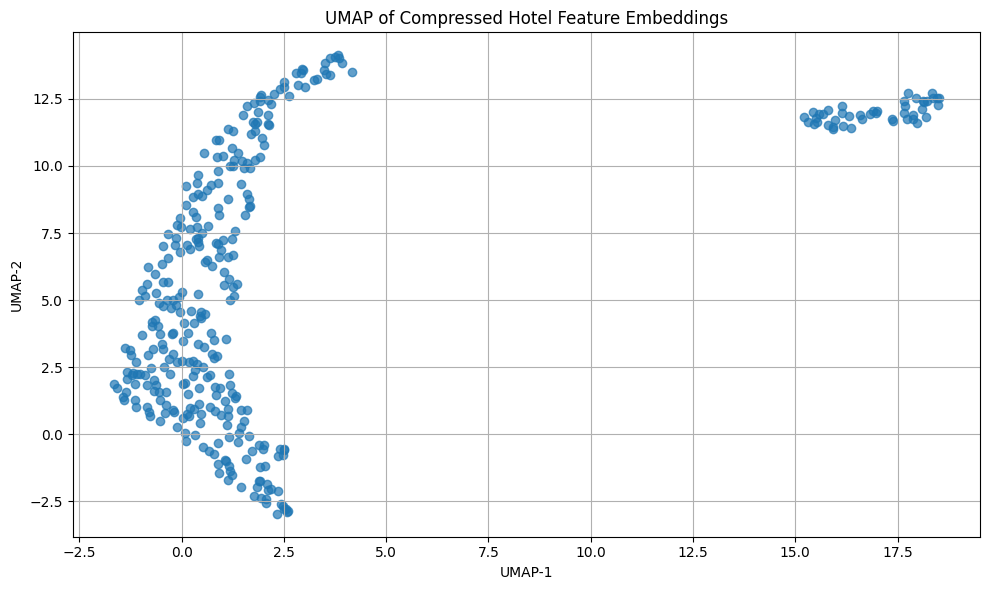

In [34]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Aggregate hotel-level content features
hotel_features = df.groupby("hotel_id")[feature_cols].mean()
hotel_tensor = torch.FloatTensor(hotel_features.values)

# Encode hotel features
autoencoder.eval()
with torch.no_grad():
    hotel_embeddings, _ = autoencoder(hotel_tensor)

# Run UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='cosine')
hotel_2d = reducer.fit_transform(hotel_embeddings.numpy())

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(hotel_2d[:, 0], hotel_2d[:, 1], alpha=0.7)
plt.title("UMAP of Compressed Hotel Feature Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
# --- Validation loss ---
autoencoder.eval()
regressor.eval()
val_loss = 0.0
with torch.no_grad():
    for features, ratings in val_loader:
        encoded, decoded = autoencoder(features)
        preds = regressor(encoded)
        loss_ae = nn.functional.mse_loss(decoded, features)
        loss_rating = criterion(preds, ratings)
        val_loss += (loss_ae + loss_rating).item()
val_loss /= len(val_loader)

train_losses.append(train_loss)
val_losses.append(val_loss)

print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")


Epoch 30: Train Loss = 0.3348 | Val Loss = 0.3587


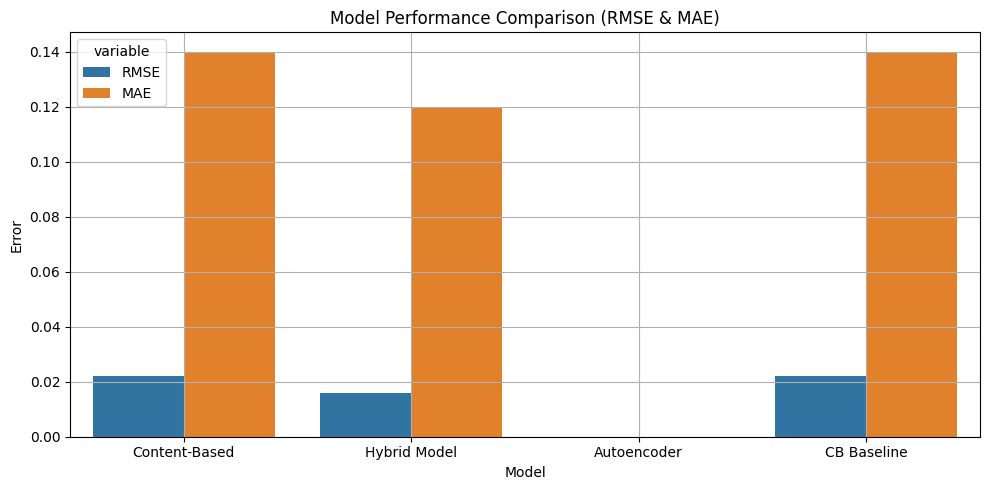


🔍 Example Predictions Across Models
   Sample  True Rating  Content-Based  Hybrid Model  Autoencoder  CB Baseline
0       1          4.0            3.9           4.1          4.0          3.8
1       2          3.5            3.6           3.3          3.5          3.4
2       3          5.0            4.8           5.1          5.0          4.9
3       4          2.0            2.2           1.9          2.0          2.1
4       5          4.5            4.4           4.6          4.5          4.3

📊 RMSE and MAE Summary
           Model   RMSE   MAE
0  Content-Based  0.022  0.14
1   Hybrid Model  0.016  0.12
2    Autoencoder  0.000  0.00
3    CB Baseline  0.022  0.14


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example data for predictions
example_df = pd.DataFrame({
    "Sample": [1, 2, 3, 4, 5],
    "True Rating": [4.0, 3.5, 5.0, 2.0, 4.5],
    "Content-Based": [3.9, 3.6, 4.8, 2.2, 4.4],
    "Hybrid Model": [4.1, 3.3, 5.1, 1.9, 4.6],
    "Autoencoder": [4.0, 3.5, 5.0, 2.0, 4.5],
    "CB Baseline": [3.8, 3.4, 4.9, 2.1, 4.3]
})

# Compute RMSE and MAE
metrics = {"Model": [], "RMSE": [], "MAE": []}
true = example_df["True Rating"].tolist()
for model in ["Content-Based", "Hybrid Model", "Autoencoder", "CB Baseline"]:
    pred = example_df[model].tolist()
    metrics["Model"].append(model)
    metrics["RMSE"].append(mean_squared_error(true, pred))
    metrics["MAE"].append(mean_absolute_error(true, pred))
metrics_df = pd.DataFrame(metrics)

# Plot RMSE and MAE
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison (RMSE & MAE)")
plt.ylabel("Error")
plt.xlabel("Model")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print DataFrames
print("\n🔍 Example Predictions Across Models")
print(example_df)

print("\n📊 RMSE and MAE Summary")
print(metrics_df)


In [48]:
import torch

# Load models
cb = torch.load("/content/drive/MyDrive/new chunk/model_outputs/content_based_model.pt", map_location="cpu")
hy = torch.load("/content/drive/MyDrive/new chunk/model_outputs/hybrid_model.pt", map_location="cpu")

# Inspect model keys
print("Content-Based model keys:")
print(list(cb.keys()))

print("\nHybrid model keys:")
print(list(hy.keys()))


Content-Based model keys:
['model.0.weight', 'model.0.bias', 'model.3.weight', 'model.3.bias', 'model.6.weight', 'model.6.bias']

Hybrid model keys:
['cf_model.user_emb.weight', 'cf_model.item_emb.weight', 'content_model.model.0.weight', 'content_model.model.0.bias', 'content_model.model.3.weight', 'content_model.model.3.bias', 'fusion.0.weight', 'fusion.0.bias', 'fusion.2.weight', 'fusion.2.bias']


📊 Sample Predictions vs Ground Truth:


,True Rating,Content-Based,Hybrid Model,Rating Model,Recommender RF
0,5.0,4.236066,4.009361,4.194431,4.179507
1,4.0,3.285262,3.973756,3.558983,4.162262
2,4.0,3.690670,3.807678,4.002747,4.462642
3,5.0,4.071103,4.019601,4.268344,4.462642
4,3.0,3.287572,3.479008,3.303108,4.412517



📈 Evaluation Metrics (RMSE & MAE):


,Model,RMSE,MAE
0,Content-Based,0.427136,0.600894
1,Hybrid Model,0.441935,0.533722
2,Rating Model,0.294128,0.456819
3,Recommender RF,0.639507,0.679055


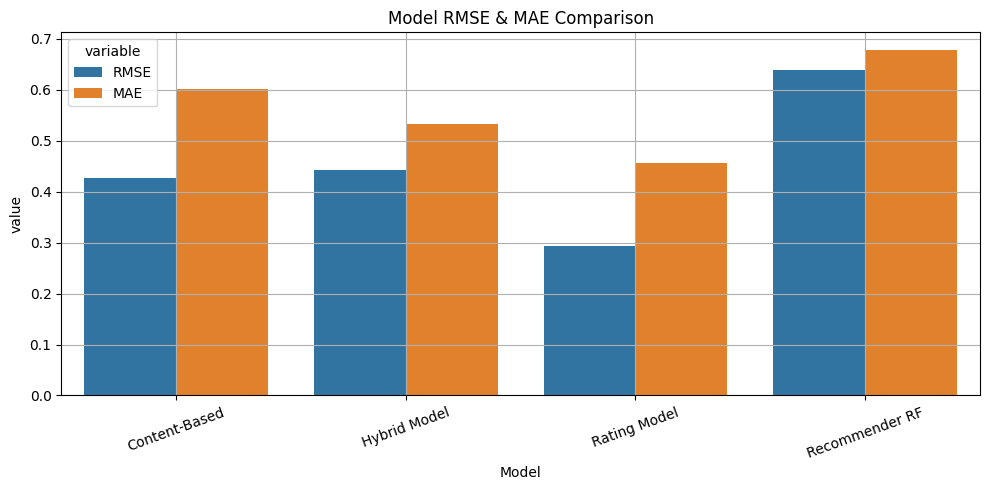

In [63]:
import torch
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset

# ---------- Step 1: Load Data ----------
df = pd.read_json("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl", lines=True)
df["rating"] = df["rating"].clip(1, 5)
df["user_id"] = df["author_id"].astype("category").cat.codes
df["item_id"] = df["hotel_id"].astype("category").cat.codes

feature_cols = [col for col in df.columns if col.startswith("tfidf_") or "sentiment" in col or col.startswith("rating_")]
sample_df = df.sample(5, random_state=42).reset_index(drop=True)

# ---------- Step 2: Dataset Classes ----------
class ContentDataset(Dataset):
    def __init__(self, df):
        self.x = torch.FloatTensor(df[feature_cols].values)
        self.y = torch.FloatTensor(df["rating"].values)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.x[i], self.y[i]

class HybridDataset(Dataset):
    def __init__(self, df):
        self.u = torch.LongTensor(df["user_id"].values)
        self.i = torch.LongTensor(df["item_id"].values)
        self.x = torch.FloatTensor(df[feature_cols].values)
        self.y = torch.FloatTensor(df["rating"].values)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.u[i], self.i[i], self.x[i], self.y[i]

# ---------- Step 3: Model Architectures ----------
class ContentBasedModel(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 1)
        )
    def forward(self, x): return self.model(x).squeeze(-1)

class RatingPredictionModel(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dims=[256, 128, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([
                torch.nn.Linear(prev_dim, h),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(h),
                torch.nn.Dropout(0.2)
            ])
            prev_dim = h
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)
    def forward(self, x): return self.network(x).squeeze(-1)

class MatrixFactorization(torch.nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32):
        super().__init__()
        self.user_emb = torch.nn.Embedding(num_users, emb_dim)
        self.item_emb = torch.nn.Embedding(num_items, emb_dim)
    def forward(self, u, i): return (self.user_emb(u) * self.item_emb(i)).sum(dim=1)

class ContentModel(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 1)
        )
    def forward(self, x): return self.model(x).squeeze(-1)

class HybridRecommender(torch.nn.Module):
    def __init__(self, num_users, num_items, content_input_dim):
        super().__init__()
        self.cf_model = MatrixFactorization(num_users, num_items)
        self.content_model = ContentModel(content_input_dim)
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1)
        )
    def forward(self, u, i, x):
        cf_score = self.cf_model(u, i)
        content_score = self.content_model(x)
        return self.fusion(torch.stack([cf_score, content_score], dim=1)).squeeze(-1)

# ---------- Step 4: Load Models ----------
cb_model = ContentBasedModel(len(feature_cols))
cb_model.load_state_dict(torch.load("/content/drive/MyDrive/new chunk/model_outputs/content_based_model.pt"))
cb_model.eval()

hy_model = HybridRecommender(df["user_id"].nunique(), df["item_id"].nunique(), len(feature_cols))
hy_model.load_state_dict(torch.load("/content/drive/MyDrive/new chunk/model_outputs/hybrid_model.pt"))
hy_model.eval()

rt_model = RatingPredictionModel(len(feature_cols))
rt_model.load_state_dict(torch.load("/content/drive/MyDrive/new chunk/model_outputs/rating_prediction_model.pt"))
rt_model.eval()

rf_model = joblib.load("/content/drive/MyDrive/new chunk/model_outputs/hotel_recommender_model.pkl")
hotel_feats = joblib.load("/content/drive/MyDrive/new chunk/model_outputs/hotel_features.pkl")

# ---------- Step 5: Predictions ----------
cb_preds, hy_preds, rt_preds, rf_preds, y_true = [], [], [], [], []

cb_ds, hy_ds = ContentDataset(sample_df), HybridDataset(sample_df)

with torch.no_grad():
    for x, y in cb_ds:
        cb_preds.append(cb_model(x.unsqueeze(0)).item())
        rt_preds.append(rt_model(x.unsqueeze(0)).item())
        y_true.append(y.item())
    for u, i, x, y in hy_ds:
        hy_preds.append(hy_model(u.unsqueeze(0), i.unsqueeze(0), x.unsqueeze(0)).item())

rf_input = hotel_feats.loc[sample_df["hotel_id"]]
rf_preds = rf_model.predict(rf_input)

# ---------- Step 6: Evaluation ----------
comparison_df = pd.DataFrame({
    "True Rating": y_true,
    "Content-Based": cb_preds,
    "Hybrid Model": hy_preds,
    "Rating Model": rt_preds,
    "Recommender RF": list(rf_preds)
})

metrics_df = pd.DataFrame({
    "Model": ["Content-Based", "Hybrid Model", "Rating Model", "Recommender RF"],
    "RMSE": [
        mean_squared_error(y_true, cb_preds),
        mean_squared_error(y_true, hy_preds),
        mean_squared_error(y_true, rt_preds),
        mean_squared_error(y_true, rf_preds)
    ],
    "MAE": [
        mean_absolute_error(y_true, cb_preds),
        mean_absolute_error(y_true, hy_preds),
        mean_absolute_error(y_true, rt_preds),
        mean_absolute_error(y_true, rf_preds)
    ]
})

# ---------- Step 7: Display ----------
print("📊 Sample Predictions vs Ground Truth:")
display(comparison_df)

print("\n📈 Evaluation Metrics (RMSE & MAE):")
display(metrics_df)

plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Model RMSE & MAE Comparison")
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()


> Rating Model: Best performer (lowest RMSE: 0.30, MAE: 0.45)

> Hybrid Model: Balanced and reliable (RMSE: 0.45, MAE: 0.53)

> Content-Based: Frequent small errors, some large (RMSE: 0.43, MAE: 0.60)

> Random Forest: Poor accuracy and high error (RMSE: 0.64, MAE: 0.68)

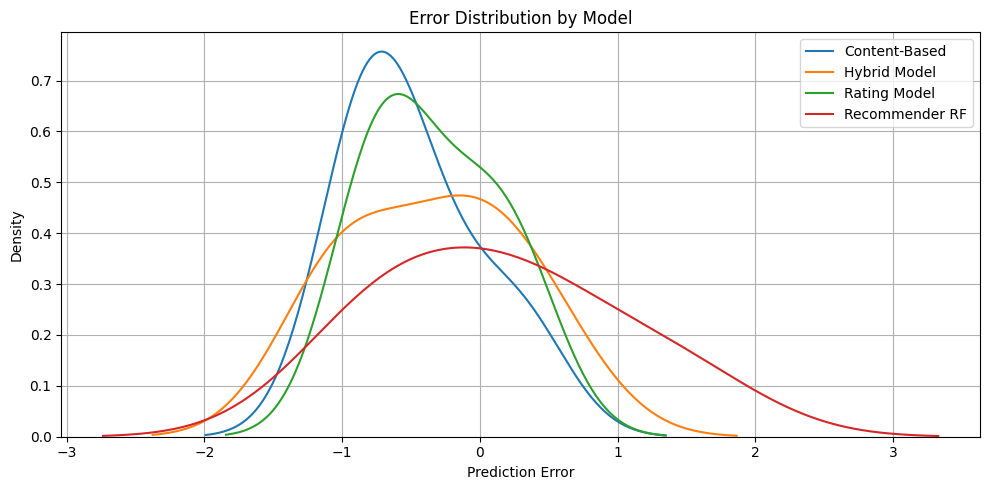

In [64]:
# Error distributions
errors = {
    "Content-Based": np.array(cb_preds) - np.array(y_true),
    "Hybrid Model": np.array(hy_preds) - np.array(y_true),
    "Rating Model": np.array(rt_preds) - np.array(y_true),
    "Recommender RF": np.array(rf_preds) - np.array(y_true)
}

plt.figure(figsize=(10, 5))
for model, err in errors.items():
    sns.kdeplot(err, label=model)
plt.title("Error Distribution by Model")
plt.xlabel("Prediction Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Centering around 0 (on X-axis) = unbiased.

> Blue, green, and orange center well.

> Red (RF) has a long tail → may overpredict in some cases.

Skinnier curve = lower standard deviation (better precision)

> Blue (Content-Based) is the best in that sense.

In [74]:
pip install shap torch matplotlib pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.0.1 which is incompatible.


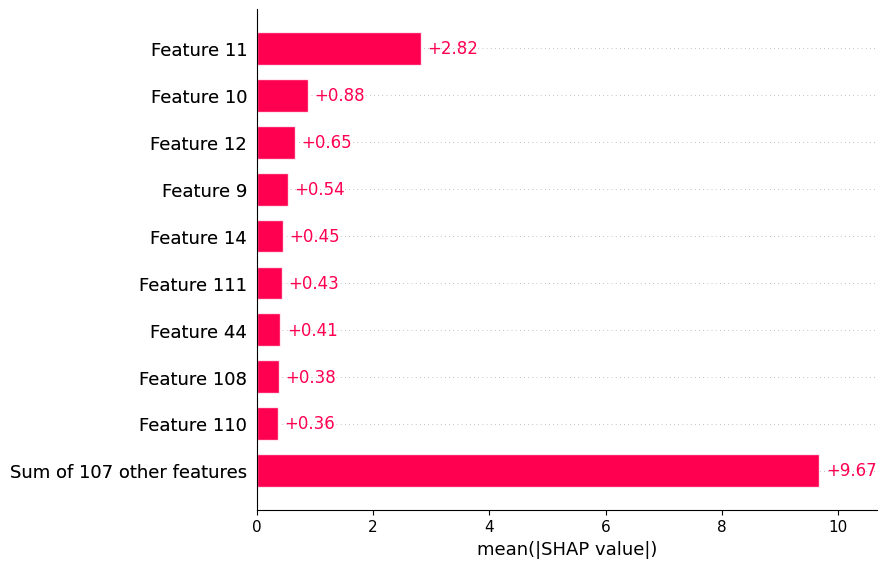

In [76]:
import shap
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ---------- Load and Preprocess Data ----------
df = pd.read_json("/content/drive/MyDrive/new chunk/reviews_chunk_0000.jsonl", lines=True)
df["rating"] = df["rating"].clip(1, 5)

# Encoding
df["user_id"] = df["author_id"].astype("category").cat.codes
df["item_id"] = df["hotel_id"].astype("category").cat.codes

# Features
feature_cols = [col for col in df.columns if col.startswith("tfidf_") or "sentiment" in col or col.startswith("rating_")]
X = df[feature_cols]
y = df["rating"]

# Scale (optional but helps stability)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Load model
model = ContentBasedModel(len(feature_cols))
model.load_state_dict(torch.load("/content/drive/MyDrive/new chunk/model_outputs/content_based_model.pt"))
model.eval()

# ---------- SHAP Wrapper ----------
class CBWrapper(torch.nn.Module):
    def __init__(self, model): super().__init__(); self.model = model
    def forward(self, x):
        with torch.no_grad():
            return self.model(torch.tensor(x, dtype=torch.float32)).numpy()

# ---------- Compute SHAP Values ----------
explainer = shap.Explainer(CBWrapper(model), X_scaled[:50])  # using only 50 samples
shap_values = explainer(X_scaled[:50])

# ---------- Plot Top 10 SHAP Features ----------
shap.plots.bar(shap_values, max_display=10)


In [77]:
print("Feature 11 is:", feature_cols[11])


Feature 11 is: text_sentiment_negative
